In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2
from moviepy.editor import VideoFileClip

%matplotlib inline

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.02547712/28549024 bytes (8.9%6275072/28549024 bytes (22.08822784/28549024 bytes (30.912263424/28549024 bytes (43.0%16187392/28549024 bytes (56.7%20094976/28549024 bytes (70.4%24068096/28549024 bytes (84.3%28114944/28549024 bytes (98.5%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.


In [2]:
def readImages(path):
    images = [cv2.imread(file) for file in glob.glob(path)]
    return images

In [3]:
def readVideo(file_name='../project_video.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images

In [ ]:
project_vid_frames = readVideo('../project_video.mp4')
project_vid_len = len(project_vid_frames)
print(project_vid_len)

In [4]:
challenge_vid_frames = readVideo('../challenge_video.mp4')
challenge_vid_len = len(challenge_vid_frames)
print(challenge_vid_len)

100%|██████████| 485/485 [00:01<00:00, 325.41it/s]

485


In [ ]:
harder_challenge_vid_frames = readVideo('../harder_challenge_video.mp4')
harder_challenge_vid_len = len(harder_challenge_vid_frames)
print(harder_challenge_vid_len)

In [5]:
def stackImages(binary_img1,binary_img2):
    combined = np.zeros_like(binary_img1)
    print(binary_img1.shape)
    combined[(binary_img1 == 1) | (binary_img2 == 1)] = 1
    return combined

In [6]:
class Camera(object):

    def __init__(self, images, chessboard_size):
        self.matrix = None
        self.dist = None
        self.calibrated_images = []
        self.failed_images = []
        self.calibrate(images, chessboard_size)

    def calibrate(self, images, chessboard_size):
        pattern = np.zeros((chessboard_size[1] * chessboard_size[0], 3), np.float32)
        pattern[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
        pattern_points = [] # points in real world image
        image_points = []   # points in image plane
        image_size = None

        # Loop through the images looking for chessboard corners
        for image in images:
            # convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            # find the chessboard corners
            f, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
            # when corners found add object and image points
            if f:
                pattern_points.append(pattern)
                image_points.append(corners)
                image_size = (image.shape[1], image.shape[0])
                # draw corners
                cv2.drawChessboardCorners(image, chessboard_size, corners, True)
#                 self.calibrated_images.append(image)
#             else:
#                 self.failed_images.append(image)

        # calibrate the camera if points were found
        if pattern_points and image_points:
            _, self.matrix, self.dist, _, _ = cv2.calibrateCamera(
                pattern_points, image_points,image_size, None, None
            )
    
    def undistort(self, image):
        if self.matrix is not None and self.dist is not None:
            return cv2.undistort(image, self.matrix, self.dist, None, self.matrix)
        else:
            return image

In [7]:
def calibrateCamera(images):
    calibrated_camera = Camera(images,(9,6))
#     plt.figure(figsize=(12, 10))
#     gridspec.GridSpec(5, 4)

#     print('Corners detected:')
#     # Loop through the images and look for the chessboard corners 
#     for i, image, in enumerate(calibrated_camera.calibrated_images):
#         plt.subplot2grid((5, 4), (i//4, i%4), colspan=1, rowspan=1)
#         plt.imshow(calibrated_camera.undistort(image))
#         plt.axis('off')
#     plt.show()

#     print('Unable to detect corners:')
#     for i, image in enumerate(images):
#         f, (x1, x2) = plt.subplots(1, 2, figsize=(25, 10))
#         x1.axis('off')
#         x1.imshow(image)
#         x1.set_title('Original', fontsize=20)
#         x2.axis('off')
#         x2.imshow(calibrated_camera.undistort(image))
#         x2.set_title('Calibrated', fontsize=20)
        
    return calibrated_camera

In [8]:
images = [cv2.imread(file) for file in glob.glob('../camera_cal/calibration*.jpg')]
calibrated_camera = calibrateCamera(images)

In [35]:
class preProcessImage(object):
    
    def __init__(self, image):
        self.image = image;
        self.img_width = image.shape[1]
        self.img_height = image.shape[0]
        self.sobelx_th = (20,100)
        self.sobely_th = (20,100)
        self.sobel_mag_th = (70,100)
        self.sobel_grad_th = (30,100)
        self.s_th = (170,255)
        self.s_th = (170,255)
        self.th_hsv_img=None
        self.th_hls_img=self.cvt2HLS(image)
        self.th_yuv_img=None
        self.th_sobelx = self.cvt2Sobelx(image)
        self.th_sobely = self.cvt2Sobely(image)
        self.gradmag = []
        self.absgraddir = []
        self.roi = []   
        self.ax = []
        self.f = []
        self.equalized_img = []
    
    def plot_images(self):
        plt.figure()
        self.f,self.ax = plt.subplots(1,7,figsize=(30,30))   

        self.ax[0].imshow(self.image) #cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.ax[0].title.set_text('image')
        self.ax[1].imshow(self.th_hls_img[:,:,1])
        self.ax[1].title.set_text('l-channel')
        self.ax[2].imshow(self.th_hls_img[:,:,2])
        self.ax[2].title.set_text('s-channel')
        self.ax[3].imshow(self.th_yuv_img[:,:,2])
        self.ax[3].title.set_text('v-channel')
        self.ax[4].imshow(self.th_yuv_img[:,:,0])
        self.ax[4].title.set_text('y-channel')
        self.clahe(self.th_yuv_img[:,:,0])
        self.ax[5].imshow(self.equalized_img)
        self.ax[5].title.set_text('y-channel-clahe')
       
        
        
        
    def getLanesRoi(self):
        x_center = self.img_width/2
        self.roi = np.array([[(0 + 50,self.img_height),
                              (x_center - 30, 50+self.img_height*1/2), 
                              (x_center + 30, 50+self.img_height*1/2), 
                              (self.img_width - 50,self.img_height)]], 
                            dtype=np.int32)

    def maskedImage(self,img=None, roi=None):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        if img is None :
            img = self.image
        
        if roi is None:
            self.getLanesRoi()
            vertices = self.roi
        else:
            vertices = roi
                
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    def binaryThresh(self, channel, thresh):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
        return binary
    
    def cvt2Gray(self,img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def cvt2HSV(self,img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
    def cvt2HLS(self,img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        
    def cvt2YUV(self,img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    
    def cvt2Sobelx(self,img):
        gray = self.cvt2Gray(img)
        return cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    def cvt2Sobely(self,img):
        gray = self.cvt2Gray(img)
        return cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    def thresholdSobelx(self):
        abs_sobelx = np.absolute(self.th_sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        self.th_sobelx = self.binaryThresh(scaled_sobel, self.sobelx_th)

    def thresholdSobely(self):
        abs_sobely = np.absolute(self.th_sobely) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
        self.th_sobely = self.binaryThresh(scaled_sobel, self.sobely_th)
        
    def sobelGradMag(self):
        gradmag = np.sqrt(self.th_sobelx**2 + self.th_sobely**2)
        scale_factor = np.max(gradmag)/255 
        self.gradmag = (gradmag/scale_factor).astype(np.uint8) 
        self.absgraddir = np.arctan2(np.absolute(self.th_sobely), np.absolute(self.th_sobelx))

    
    def thresholdSobelMag(self):
        self.sobelGradMag()
        self.gradmag = self.binaryThresh(self.gradmag, self.sobel_mag_th)
        
    def thresholdSobelgrad(self):
        self.sobelGradMag()
        self.dir_binary = self.binaryThresh(self.absgraddir, self.dir_thresh)
        
    def filterWhiteYellow(self):
        filtered_img =  np.zeros_like(self.image[:,:,0])
        white_img =  np.zeros_like(self.image[:,:,0])
        yellow_img =  np.zeros_like(self.image[:,:,0])

        self.th_hsv_img=self.cvt2HSV(self.image)
        self.th_yuv_img=self.cvt2YUV(self.image)
        #Filter white
        threshold = 200 
        high_threshold = np.array([255, 255, 255]) #Bright white
        low_threshold = np.array([threshold, threshold, threshold]) #Soft White
        b_th = self.binaryThresh(self.image[:,:,0], (200,255))
        g_th = self.binaryThresh(self.image[:,:,1], (200,255))
        r_th = self.binaryThresh(self.image[:,:,2], (200,255))
        self.clahe(self.th_yuv_img[:,:,0])
        y_white_th = self.binaryThresh(self.equalized_img, (50,255))

        
        white_img[((r_th == 1) & (b_th == 1) & (g_th == 1) & (y_white_th == 1) )] = 1

        # Filter Yellow
        high_threshold = np.array([110,255,255]) #Bright Yellow
        low_threshold = np.array([0,100,50]) #Soft Yellow   
        
        h_th = self.binaryThresh(self.th_hsv_img[:,:,0], (0,110))
        s_th = self.binaryThresh(self.th_hsv_img[:,:,1], (110,255))
        v_th = self.binaryThresh(self.th_hsv_img[:,:,2], (50,255))
        #y_yellow_th = self.binaryThresh(self.th_yuv_img[:,:,0], (50,255))
        
        yellow_img[((s_th ==1) & (v_th == 1) & (y_white_th == 1))] = 1
        
        
        filtered_img[(white_img == 1 ) | (yellow_img == 1)] = 1

        return filtered_img
         
    def clahe(self,image=None):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        self.equalized_img = clahe.apply(image)
        
    def processThreshold(self):
        filtered_image = self.filterWhiteYellow()
        self.thresholdSobelx()
        self.thresholdSobelMag()
#         s_binary = self.binaryThresh(self.th_hls_img[:,:,2], self.s_th)
#         u_binary = self.binaryThresh(self.th_yuv_img[:,:,1], (0,100))
        
        filtered_image[(filtered_image == 1) | (self.gradmag == 1) | (self.th_sobelx == 1)] = 1

        return filtered_image

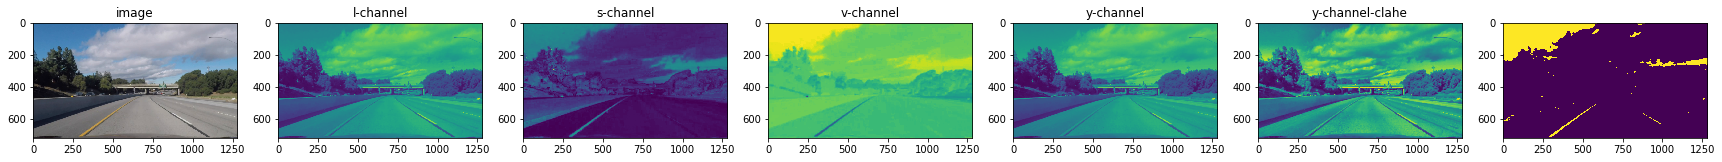

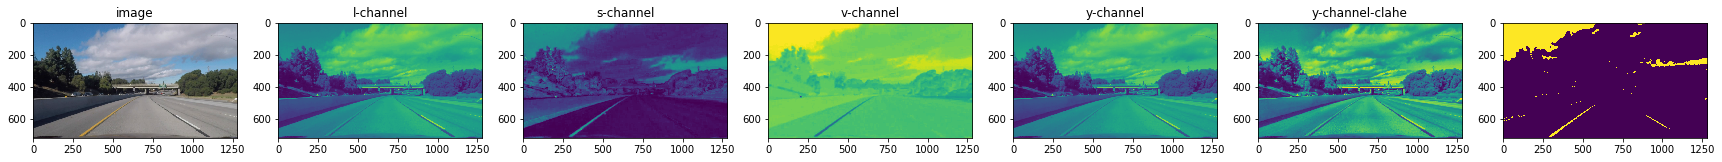

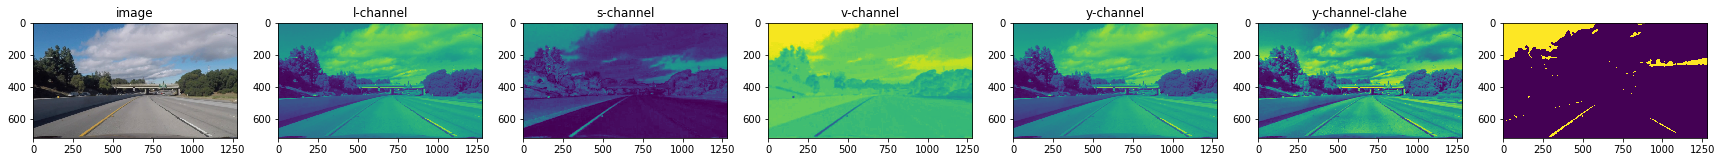

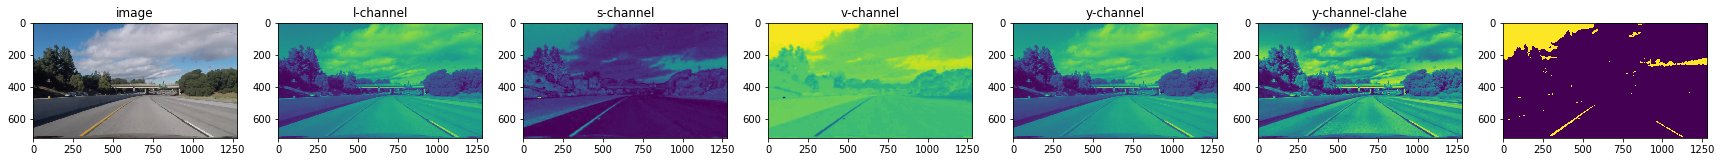

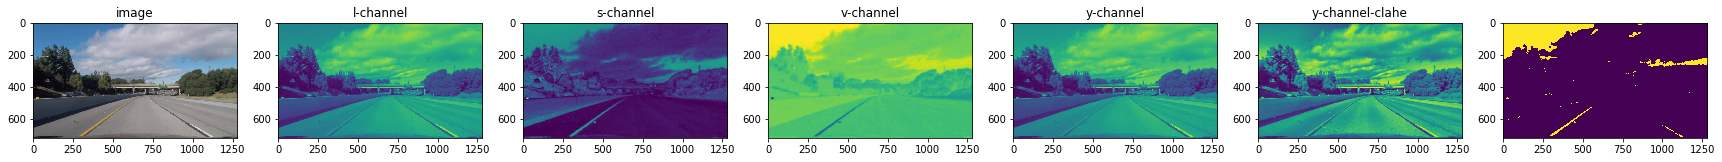

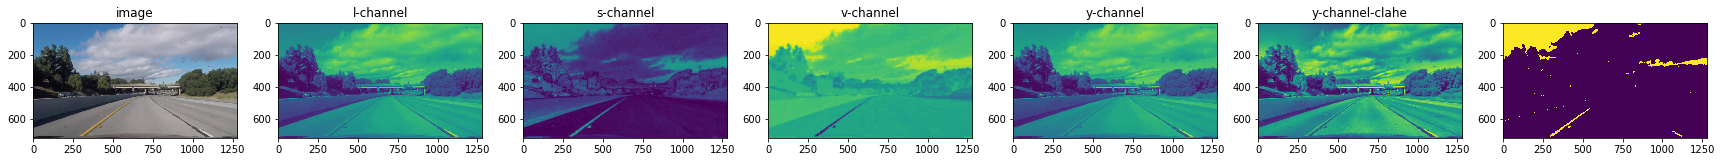

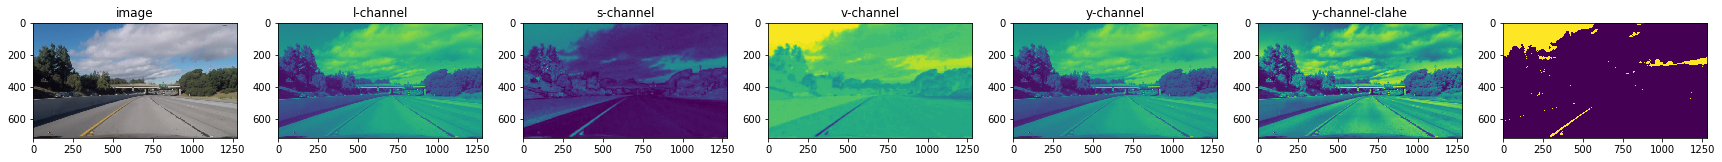

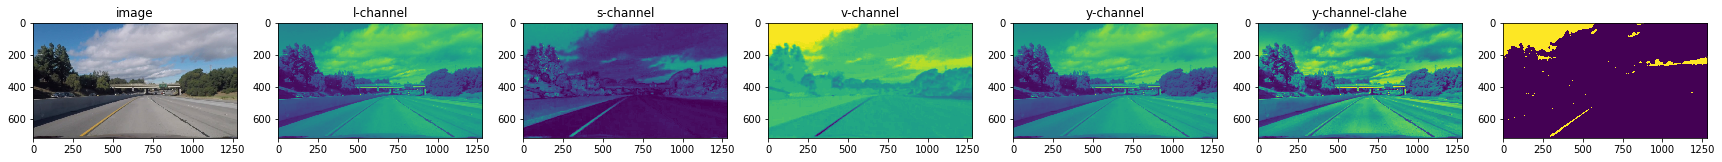

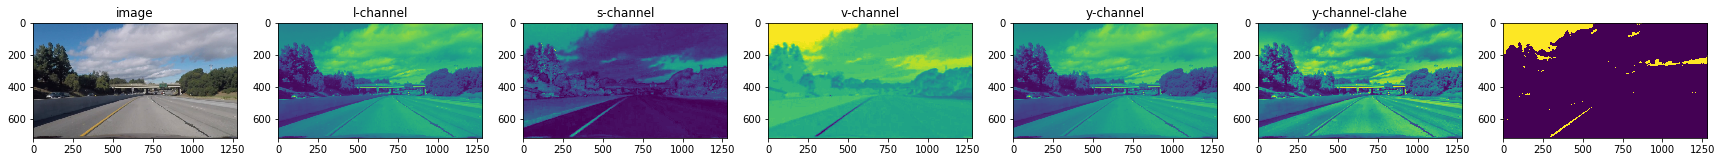

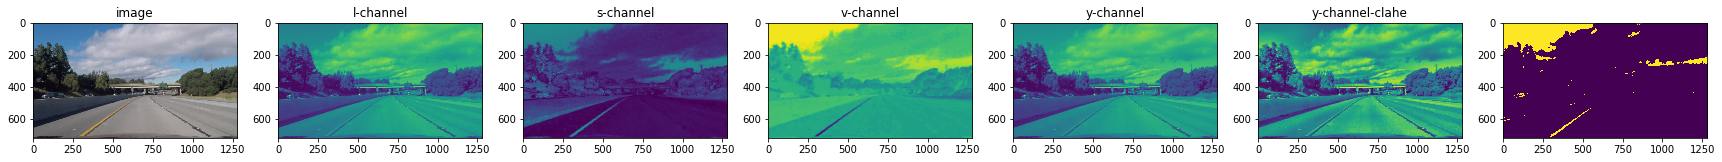

In [36]:
#road_imgs = readImages('../test_images/*.jpg')
count = 0
for i in range(0, 10):
    f,image = challenge_vid_frames[i]
#     plt.figure(count)
#     f,ax = plt.subplots(1,2,figsize=(20,10))   
    count = count + 1
    undistorted_img = calibrated_camera.undistort(image)
#     ax[0].imshow(undistorted_img)
    processed_frame = preProcessImage(undistorted_img)
    binary_th = processed_frame.processThreshold()
    processed_frame.plot_images()
    processed_frame.ax[6].imshow(binary_th)
    
    
    
#     count = count + 1
# for image in road_imgs:
#     processed_frame = preProcessImage(image)
#     processed_frame.plot_images()
#     binary_th = processed_frame.processThreshold()
#     processed_frame.ax[7].imshow(binary_th) #cv2.cvtColor(binary_th,cv2.COLOR_BGR2RGB)
#     processed_frame.ax[7].title.set_text("Stacked")
#     plt.imshow(binary_th)
#     plt.title.set_text("Stacked")


    

In [43]:
class transformImage(object):
    
    def __init__(self,image):
        self.image              = image
        self.img_size           = (image.shape[0], image.shape[1])
        self.img_height         = image.shape[1]
        self.img_width          = image.shape[0]
        self.bottom_width       = 0.4
        self.top_width          = 0.096
        self.height             = 0.4
        self.car_hood           = 45
        self.src_coordinates    = []
        self.dst_coordinates    = []
        self.transform_mtx      = []
        self.inv_transform_mtx  = []
        self.img_shape          = (image.shape[0], image.shape[1])
    
    def orderPoints(self,pts):
        mx = np.sum(pts.T[0]/len(pts))
        my = np.sum(pts.T[1]/len(pts))

        l = []
        for i in range(len(pts)):
            l.append(  (np.math.atan2(pts.T[0][i] - mx, pts.T[1][i] - my) + 2 * np.pi + 0.5 * np.pi) % (2*np.pi)  )
        sort_idx = np.argsort(l)

        return pts[sort_idx[::-1]]

    def getPerspectiveTransformMtx(self):
        self.getSrcTransformCoordinates(self.bottom_width, self.top_width, self.height, self.car_hood)
        self.getDstTransformCoordinates()
#         print('Src coordinates: ', self.src_coordinates)
#         print('Dst coordinates: ', self.dst_coordinates)
        
#         img = preProcessImage(self.image)
#         masked_img = img.maskedImage(self.image, self.src_coordinates)
#         plt.imshow(cv2.cvtColor(masked_img,cv2.COLOR_BGR2RGB))
        
        self.transform_mtx = cv2.getPerspectiveTransform(self.src_coordinates, self.dst_coordinates)
        self.inv_transform_mtx = cv2.getPerspectiveTransform(self.dst_coordinates, self.src_coordinates)
     
    def getSrcTransformCoordinates(self, bottom_width,top_width,height, car_hood):
        imshape = self.img_size
#         gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
#         histogram = np.sum(gray[gray.shape[0]-car_hood-50:gray.shape[0]-car_hood,:], axis=0)
#         midpoint = np.int(histogram.shape[0]//2)
#         leftx_base = np.int(np.argmax(histogram[:midpoint]))
#         rightx_base = np.int(np.argmax(histogram[midpoint:]) + midpoint)
#         bottomy = gray.shape[0] - 1 - car_hood
        
#         src1 = (leftx_base, bottomy)
#         src2 = (rightx_base, bottomy)
        
#         histogram = np.sum(gray[gray.shape[0]-car_hood-200:gray.shape[0]-car_hood-150,:], axis=0)
#         midpoint = np.int(histogram.shape[0]//2)
#         leftx_base = np.int(np.argmax(histogram[:midpoint]))
#         rightx_base = np.int(np.argmax(histogram[midpoint:]) + midpoint)
#         topy = gray.shape[0]-car_hood-150
        
#         src3 = (leftx_base, topy)
#         src4 = (rightx_base, topy)
        
#         self.src_coordinates = np.array([[src1, src2,src3,src4]]
#                                         , dtype = np.int32)
        

        self.src_coordinates = np.array([[\
        ((imshape[1] * (1 - bottom_width)) // 2, imshape[0]-car_hood),\
        ((imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height + car_hood),\
        (imshape[1] - (imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height + car_hood),\
        (imshape[1] - (imshape[1] * (1 - bottom_width)) // 2, imshape[0] - car_hood)]]\
        , dtype=np.int32)

        
        self.src_coordinates = self.src_coordinates.reshape(self.src_coordinates.shape[1:])
        self.src_coordinates = self.src_coordinates.astype(np.float32)
        self.src_coordinates = self.orderPoints(self.src_coordinates)
        
    def getDstTransformCoordinates(self):
        offset = 200
        self.dst_coordinates = np.float32([[offset, offset], [self.img_size[0]-offset, offset], 
                                     [self.img_size[0]-offset, self.img_size[1]], 
                                     [offset, self.img_size[1]]])
                                           
            
        
        
    def __call__(self,image=None):
        self.getPerspectiveTransformMtx()
        if image is None:
            image = self.image
        img_size = (image.shape[0], image.shape[1])
        warped = cv2.warpPerspective(image, self.transform_mtx, img_size)
        return warped 

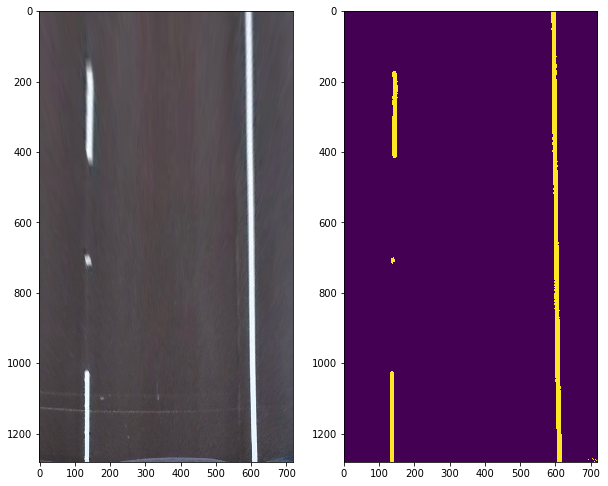

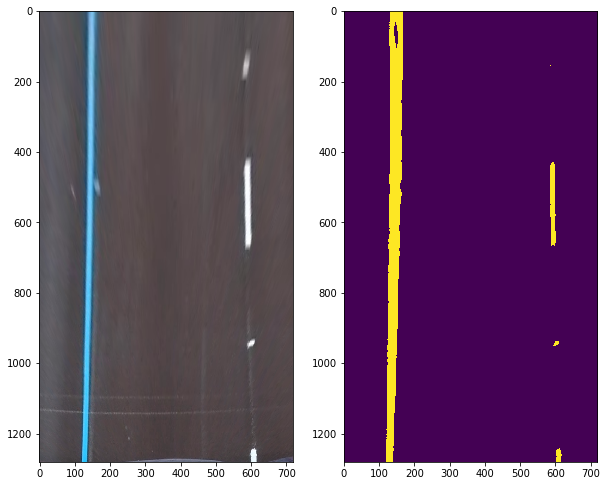

In [45]:
road_imgs = readImages('../test_images/straight_lines*.jpg')


count = 0
for image in road_imgs:
    plt.figure(count)
    f,ax = plt.subplots(1,2,figsize=(10,20))
    count = count +1
    warped = transformImage(image)
    transformed = warped()
    processed_frame = preProcessImage(transformed)
    binary_th = processed_frame.processThreshold()
    
    ax[0].imshow(transformed)
    ax[1].imshow(binary_th)

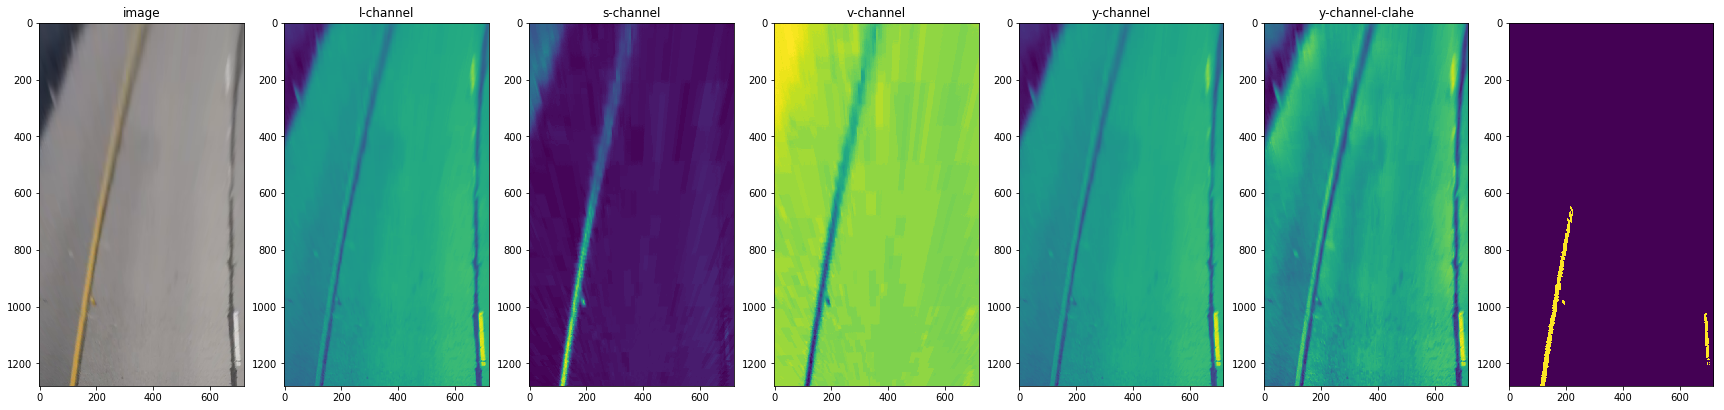

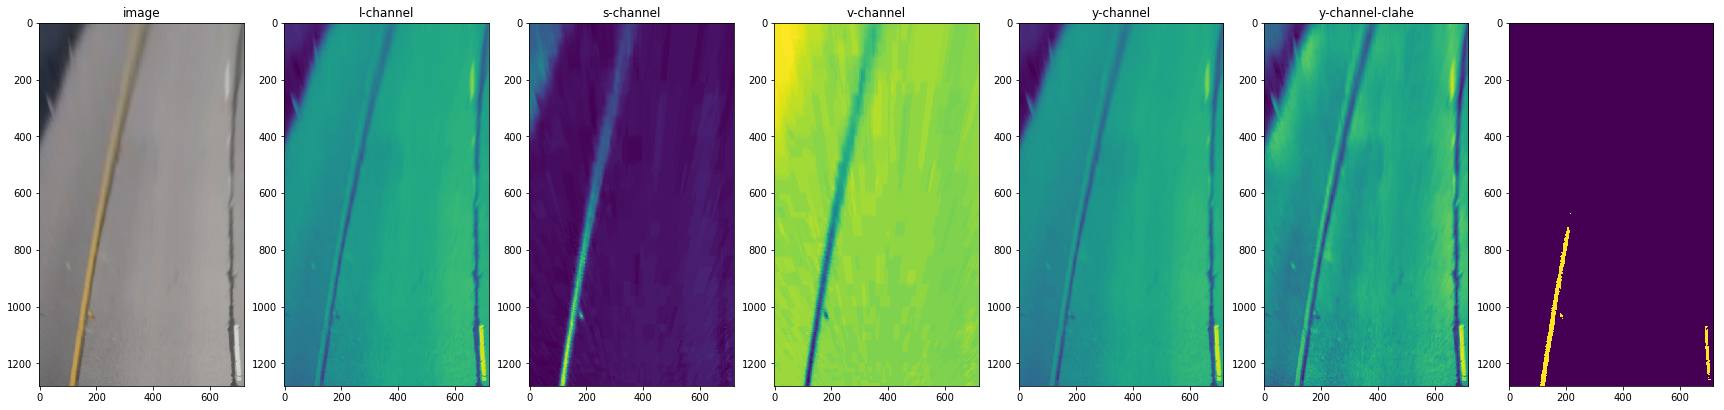

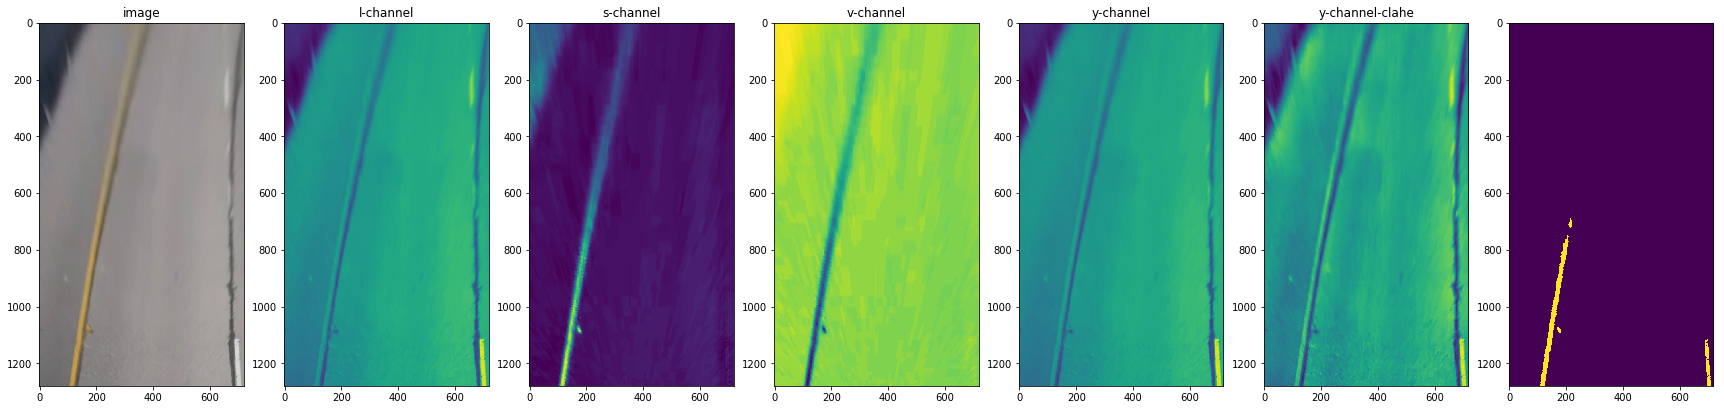

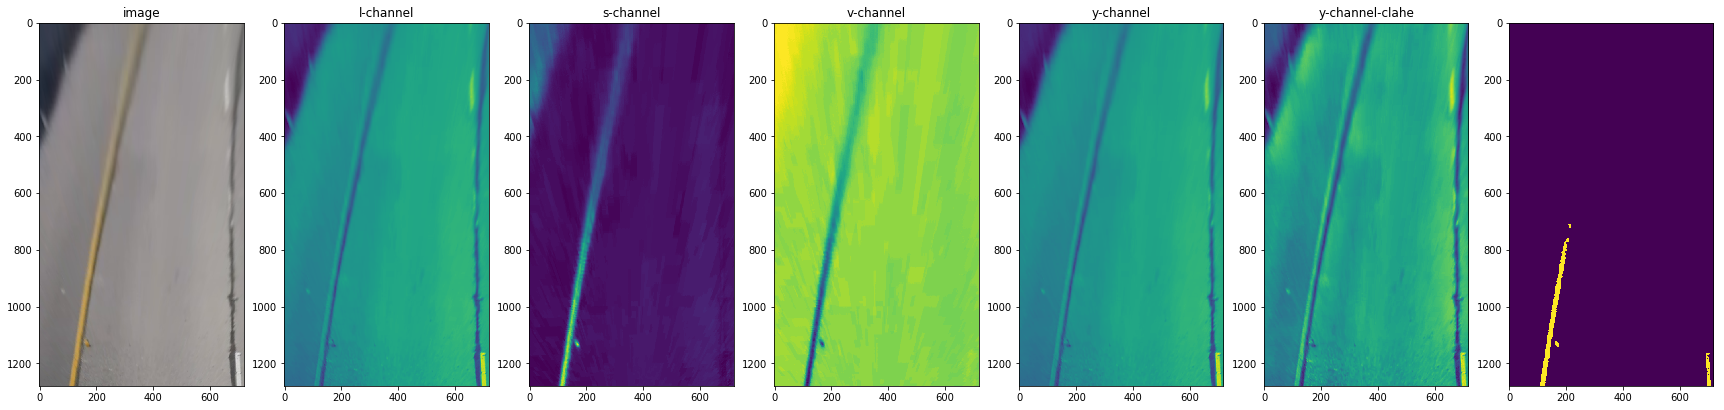

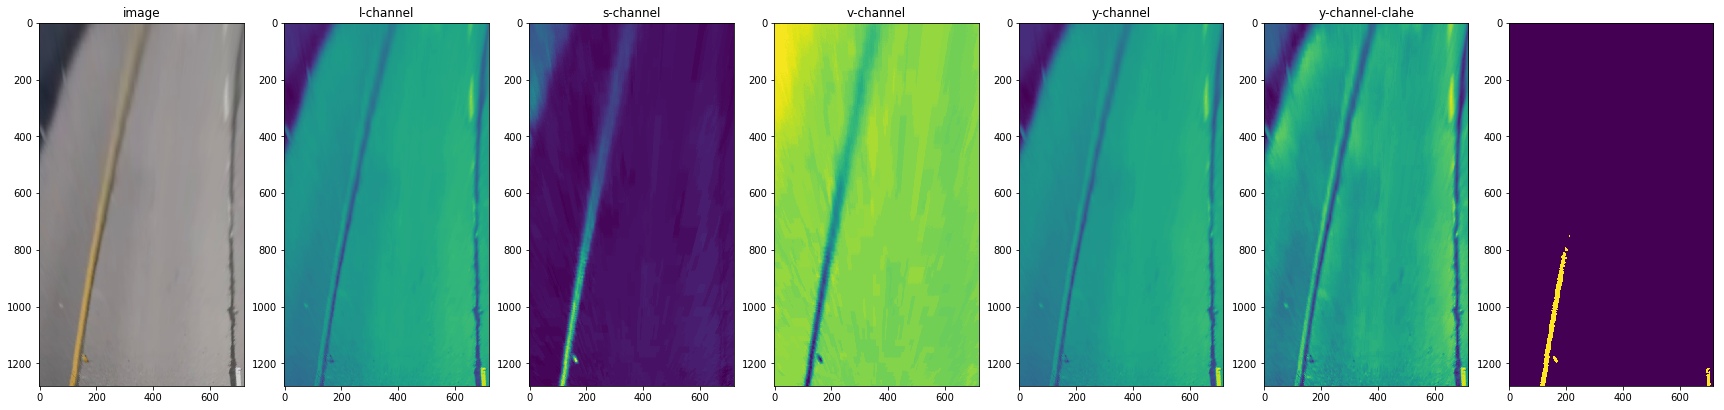

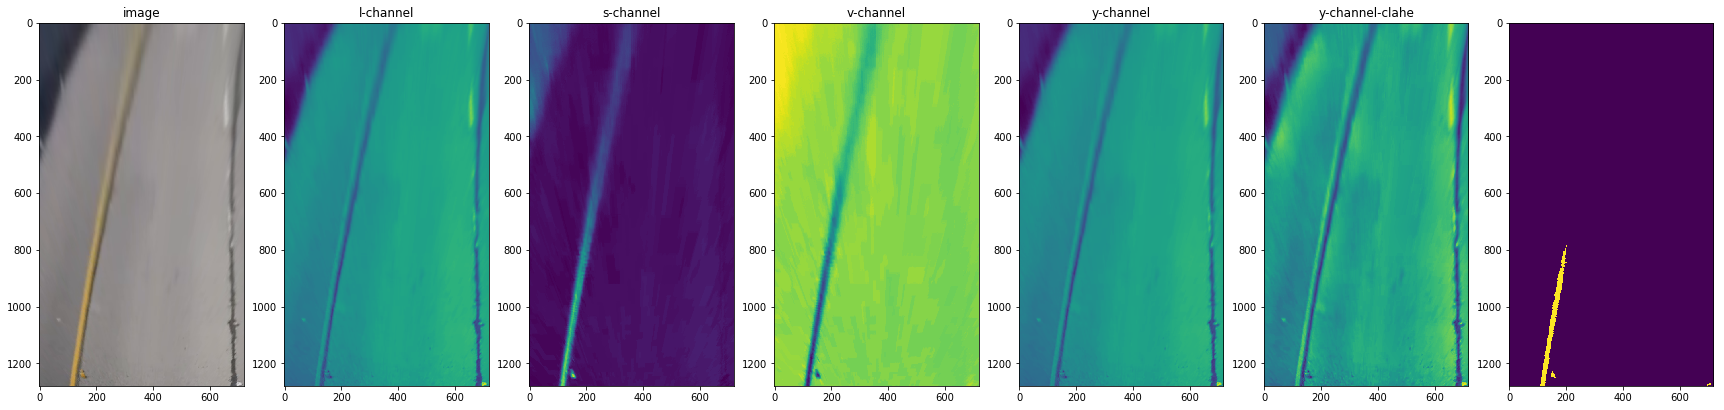

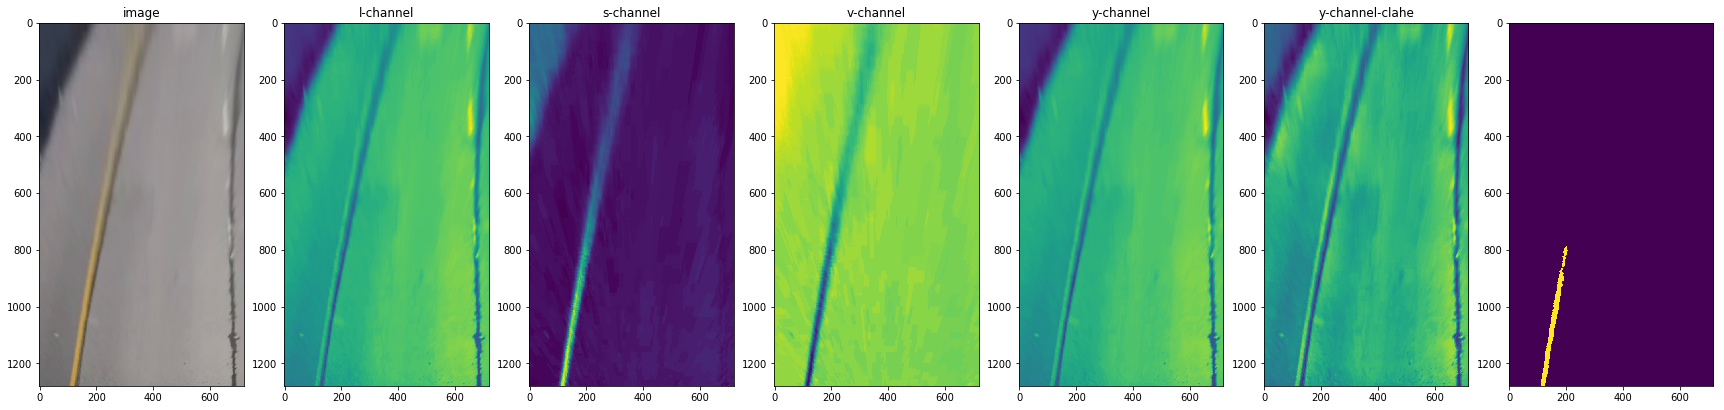

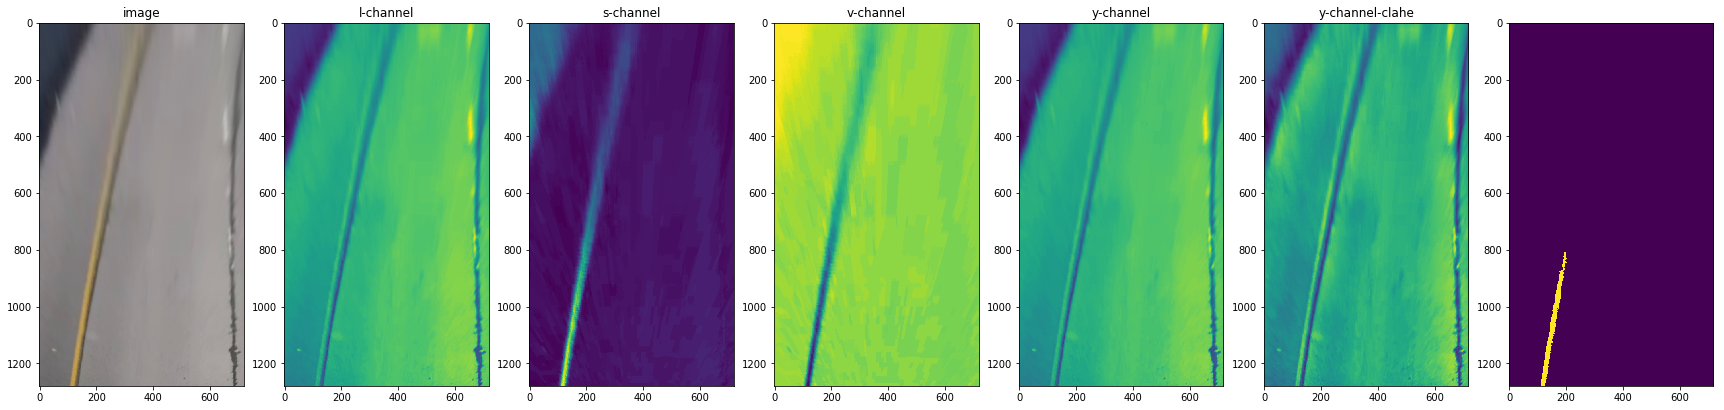

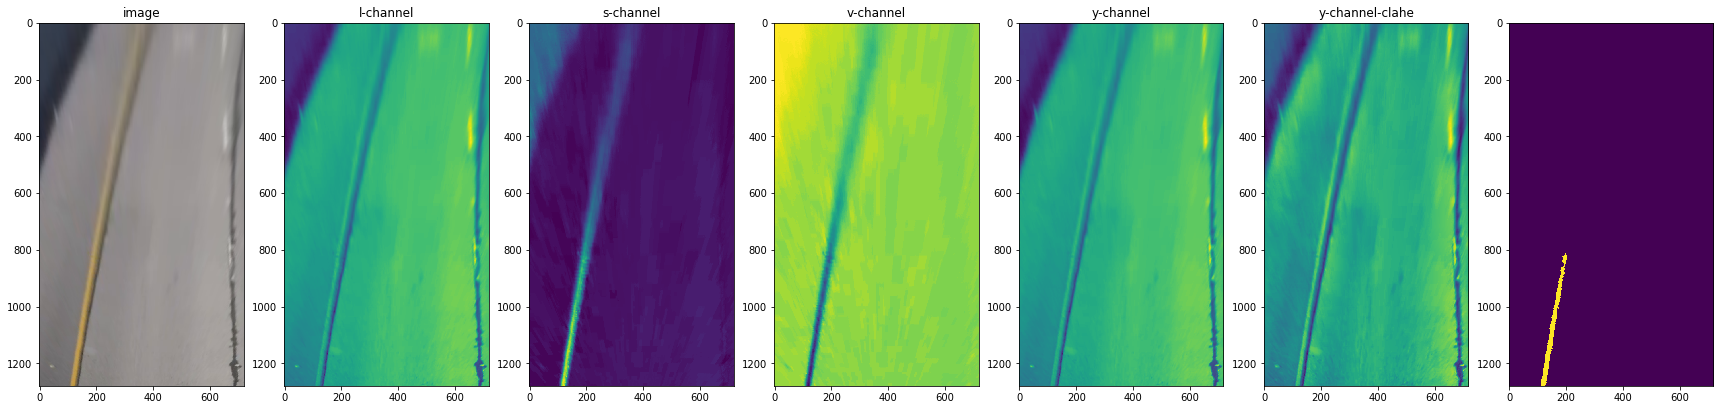

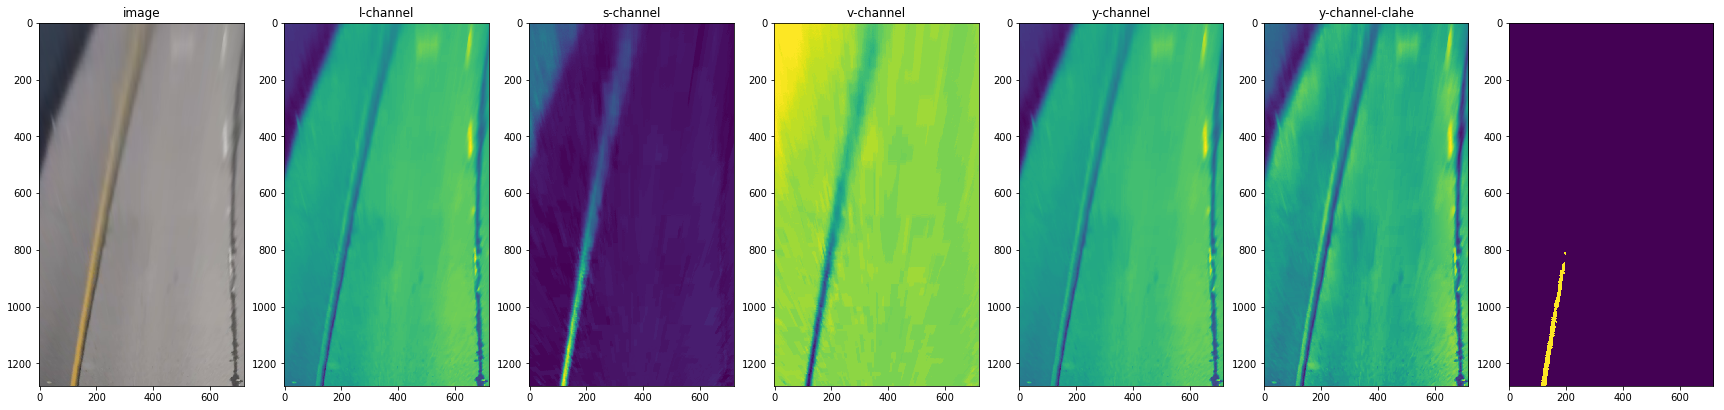

In [42]:
count = 0
for i in range(0, 10):
    f,image = challenge_vid_frames[i]  
    count = count + 1
    undistorted_img = calibrated_camera.undistort(image)
    transformed = warped(undistorted_img)
    processed_frame = preProcessImage(transformed)
    binary_th = processed_frame.processThreshold()
    processed_frame.plot_images()
    processed_frame.ax[6].imshow(binary_th)

In [ ]:
road_imgs = readImages('../test_images/test*.jpg')
for i in range(900, 910):
    f,image = project_vid_frames[i]
    plt.figure(count)
    f,ax = plt.subplots(1,2,figsize=(30,30))   

    count = count + 1
    undistorted_img = calibrated_camera.undistort(image)
    ax[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    processed_frame = preProcessImage(undistorted_img)
    binary_th = processed_frame.processThreshold()
    transformed = warped(binary_th)
    ax[1].imshow(transformed)
    count = count + 1

In [ ]:
class SlidingWindow(object):
    def __init__(self, bin_img, x_center, y_base, width=100, height=80, mincount=50, lane_found=False):
        self.image = bin_img
        self.x_center = x_center
        self.y_bottom = y_base
        self.width = width
        self.height = height
        self.mincount = mincount
        self.lane_found = lane_found
        
        self.x_bottoml = int(self.x_center - self.width/2)
        self.x_bottomr = int(self.x_center + self.width/2)
        self.y_top     = self.y_bottom - self.height
#         if self.y_top < 0:
#             self.y_top = 0
#         print(self.x_bottoml)
#         print(self.x_bottomr)
#         print(self.y_bottom)
#         print(self.y_top)

        self.window    = bin_img[self.y_top:self.y_bottom,
                                self.x_bottoml:self.x_bottomr]
        self.nonzeroy = self.window.nonzero()[0]
        self.nonzerox = self.window.nonzero()[1]
        self.activated_pixels = len(self.nonzeroy)
            
    def isNoise(self):
        return len(self.nonzerox) > (self.window.shape[0] * self.window.shape[1] *0.80)
        
    def hasLine(self):
        return (len(self.nonzerox) > self.mincount) ^ self.isNoise()
    
    def nextWindow(self):
        if self.hasLine():
            x_center = np.int(np.mean(self.nonzerox + self.x_bottoml))
        else:
            x_center = self.x_center
            
        y_bottom = self.y_top 
        
        return SlidingWindow(self.image, x_center, y_bottom, 
                         width=self.width, height=self.height, mincount = self.mincount,
                         lane_found=self.lane_found)
     



In [ ]:
class Line(object):
    def __init__(self):
        self.lanex = []
        self.laney = []
        self.curr_lane_fitx = None
        self.prev_lane_fitx = None
        self.ploty = None
        self.lane_found = False
        self.windows = []
        self.lane_inds = None
        self.basex = None
        self.windowing_method = True
        self.window_margin = 100
        self.prior_search_margin = 75
        self.prev_fit_eqn = None
        self.curr_fit_eqn = None
        self.line_fit_history = []
        self.curvature_m = None
        self.imshape = None
        self.distance_from_center_m = None
        self.lost_lane_track = 0
        
    
    def __call__(self, bin_img, side = "Left"):
        self.imshape = bin_img.shape
        if not self.lane_found and not self.lost_lane_track >= 5 :
            histogram = np.sum(bin_img[bin_img.shape[0]//2:,:], axis=0)
            midpoint = np.int(histogram.shape[0]//2)
            if side is "Left" :
                self.basex = np.argmax(histogram[:midpoint])
                
            elif side is "Right" :
                self.basex = np.argmax(histogram[midpoint:]) + midpoint
            
            print("sliding window method")
            self.findLanePixels(bin_img,self.basex)
            
        else:
            print("Searching from prior")
            self.prev_lane_fitx = self.curr_lane_fitx
            self.searchFromPrior(bin_img)
            if(len(self.laney) == 0) or not self.isValid():
                self.findLanePixels(bin_img,self.basex)
            
        if (len(self.laney) > 0):
            self.fit_polynomial(bin_img)
            
        if not self.isValid():
            self.update_lane_fitx(bin_img)
    
    def isValid(self):
        if len(self.line_fit_history) > 0 :
            y_bottom = np.max(self.ploty)
            y_top = np.min(self.ploty)
            prev_x_top = self.getX(y_top, self.line_fit_history[-1])
            prev_x_bottom = self.getX(y_bottom, self.line_fit_history[-1])
            x_top = self.getX(y_top, self.curr_fit_eqn)
            x_bottom = self.getX(y_bottom, self.curr_fit_eqn)
            
            if(np.abs(x_top - prev_x_top) < 100  or np.abs(x_b0ttom - prev_x_bottom)  <  100):
                self.line_fit_history.append(self.curr_fit_eqn)
                return True
            else:
                self.curr_fit_eqn = self.line_fit_history[-1]
                self.lane_found = False
                self.lost_lane_track = self.lost_lane_track + 1
                return False
        else:
            self.line_fit_history.append(self.curr_fit_eqn)
            return True

            
        
        
    def findLanePixels(self, binary_warped, base):
        nwindows = rem_wins = 20
        margin = self.window_margin
        minpix = 50
        
        
        window_height = np.int(binary_warped.shape[0]//nwindows)
        lost_win_count = 0
                        
        win = SlidingWindow(binary_warped, base, binary_warped.shape[0]-1, margin, window_height, minpix)
        
        continue_win_search =True
        
        while ((rem_wins >= 0) and win.y_top >= 0 ):
            
            rem_wins = rem_wins - 1
            if (win.hasLine()):
                self.windows.append(win)
            else:
                lost_win_count = lost_win_count + 1
                            
            win = win.nextWindow()
        
        if win:
            self.lanex = np.concatenate([win.nonzerox + win.x_bottoml for win in self.windows])
            self.laney = np.concatenate([win.nonzeroy + win.y_top for win in self.windows]) 
            self.lane_found = True
                
        else :
            self.lane_found = False
        self.windowing_method = True
    
    def searchFromPrior(self,binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = self.prior_search_margin

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        self.prev_fit_eqn = self.curr_fit_eqn
        
        
        n = len(self.line_fit_history)
        frames_to_take_avg = 10
        
        if n > frames_to_take_avg:
            n = frames_to_take_avg
        
      
        
        arr = np.array(self.line_fit_history[-n:])
        print(len(arr))

        avg_fit = arr.mean(axis =0)
        print(len(avg_fit))
        
        self.lane_inds = ((nonzerox > 
                          (avg_fit[0]*(nonzeroy**2) + avg_fit[1]*nonzeroy + 
                            avg_fit[2] - margin)) & 
                          (nonzerox < 
                          (avg_fit[0]*(nonzeroy**2) + 
                        avg_fit[1]*nonzeroy + avg_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        self.lanex = nonzerox[self.lane_inds]
        self.laney = nonzeroy[self.lane_inds] 
        
        if len(self.lanex) > 0:
            self.lane_found = True
            self.lost_lane_track = 0
        else:
            self.lane_found = False
            self.lost_lane_track = self.lost_lane_track + 1
        
        self.windowing_method = False   
        
    
    def fit_polynomial(self, binary_warped):
    
        self.curr_fit_eqn = np.polyfit(self.laney, self.lanex, 2)
        
        self.ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
        
        try:
            self.curr_lane_fitx = self.curr_fit_eqn[0]*self.ploty**2 + self.curr_fit_eqn[1]*self.ploty + self.curr_fit_eqn[2]
        except TypeError:
            print('The function failed to fit a line!')
            self.curr_lane_fitx = 1*self.ploty**2 + 1*self.ploty
            
    def update_lane_fitx(self, binary_warped):
    
        self.ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
        
        try:
            self.curr_lane_fitx = self.curr_fit_eqn[0]*self.ploty**2 + self.curr_fit_eqn[1]*self.ploty + self.curr_fit_eqn[2]
        except TypeError:
            print('The function failed to fit a line!')
            self.curr_lane_fitx = 1*self.ploty**2 + 1*self.ploty
    
    def getX(self,y, line):
        return(line[0]*y**2 + line[1]*y + line[2])
    
    def getCurvatureRadius(self):
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)

        # Calculation of R_curve (radius of curvature)
        self.curvature_m = ((1 + (2*self.curr_fit_eqn[0]*y_eval*ym_per_pix + self.curr_fit_eqn[1])**2)**1.5) / np.absolute(2*self.curr_fit_eqn[0])
        return self.curbature_m
        
    def getDistanceFromCenter(self):
        xm_per_pix = 30/720
        
        points = self.generate_points()
        x = curr_lane_fitx[np.max(curr_lane_fitx[:, 1])][0]
        self.distance_from_center_m = np.absolute((self.imshape[1] // 2 - x) * xm_per_pix)
        return self.distance_from_center_m

In [ ]:
def printBool(val):
    if val:
        return "True"
    else:
        return "False"

In [ ]:
class RoadLanes(object):
    def __init__(self):
        self.leftx = []
        self.lefty = []
        self.rightx = []
        self.righty = []
        self.curr_left_lane_fit = []
        self.curr_right_lane_fit = []
        self.prev_left_lane_fit = []
        self.prev_right_lane_fit = []
        self.left_lane_found = False
        self.right_lane_found = False
        self.leftx_base = []
        self.rightx_base = []
        self.left_lane = Line()
        self.right_lane = Line()
        self.f = None
        self.ax = None
        self.left_lane_history = []
        self.right_lane_history = []
    
    def reset(self):
        self.leftx = []
        self.lefty = []
        self.rightx = []
        self.righty = []
        self.curr_left_lane_fit = []
        self.curr_right_lane_fit = []
        self.prev_left_lane_fit = []
        self.prev_right_lane_fit = []
        self.left_lane_found = False
        self.right_lane_found = False
        self.leftx_base = None
        self.rightx_base = None
        self.left_lane = Line()
        self.right_lane = Line()
        self.f = None
        self.ax = None
    
    def getX(self,y, line):
        return(line[0]*y**2 + line[1]*y + line[2])
        
    def laneDebugPrint(self):
        
        print("Left side: ")
        print("\t Lane found: " + printBool(self.left_lane.lane_found))
        print("Right side: ")
        print("\t Lane found: " + printBool(self.right_lane.lane_found))
        
#     def isValid(self):
#         if (len(self.left_lane_history) > 0 and len(self.right_lane_history) > 0 ):
            
        
        
    def findRoadLanes(self,bin_img):
        self.left_lane(bin_img, "Left")
        self.right_lane(bin_img, "Right")
    
    
        
    
    def plotRoadLanes(self,bin_img):
        self.x, self.ax = plt.subplots(1,4,figsize=(20,10))
        plt.figure()
        self.ax[1].imshow(bin_img)
        self.ax[1].title.set_text('Thresholded image')
            
        out_img = np.dstack((bin_img, bin_img, bin_img))
        
        out_img[self.left_lane.laney, self.left_lane.lanex] = [255, 0, 0]
        out_img[self.right_lane.laney, self.right_lane.lanex] = [0, 0, 255]
        
        if (self.left_lane.windowing_method):
            for win in (self.left_lane.windows):
                cv2.rectangle(out_img,(win.x_bottoml,win.y_bottom),
                (win.x_bottomr,win.y_top),(0,255,0), 2)
                
        if (self.right_lane.windowing_method):
            for win in (self.right_lane.windows):
                cv2.rectangle(out_img,(win.x_bottoml,win.y_bottom),
                (win.x_bottomr,win.y_top),(0,255,0), 2)
            
        self.ax[2].imshow(out_img)
        self.ax[2].title.set_text('Found Lanes')

        self.ax[2].plot(self.left_lane.curr_lane_fitx, self.left_lane.ploty, color='yellow')
        self.ax[2].plot(self.right_lane.curr_lane_fitx, self.right_lane.ploty, color='yellow')

        if not self.left_lane.windowing_method : 
            self.ax[2].fill_betweenx(self.left_lane.ploty, 
                                     self.left_lane.curr_lane_fitx-self.left_lane.prior_search_margin,
                                     self.left_lane.curr_lane_fitx+self.left_lane.prior_search_margin,
                                     alpha=0.3,color='blue')
            
        if not self.right_lane.windowing_method : 
            self.ax[2].fill_betweenx(self.right_lane.ploty, 
                                     self.right_lane.curr_lane_fitx-self.right_lane.prior_search_margin,
                                     self.right_lane.curr_lane_fitx+self.right_lane.prior_search_margin,
                                     alpha=0.3,color='blue')
            

In [ ]:
road_lanes = RoadLanes()

In [ ]:
def drawRoadLanes(image):
    undistorted_img = calibrated_camera.undistort(image)
    processed_frame = preProcessImage(undistorted_img)
    binary_th = processed_frame.processThreshold()
    transformed = warped(binary_th)
    road_lanes.findRoadLanes(transformed)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(transformed).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = road_lanes.left_lane.curr_lane_fitx
    right_fitx = road_lanes.right_lane.curr_lane_fitx
    ploty = road_lanes.left_lane.ploty
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, warped.inv_transform_mtx, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return result

In [ ]:
road_imgs = readImages('../test_images/test*.jpg')
count = 1
for image in road_imgs:
    road_lanes.reset()
    plt.figure()
    drawRoadLanes(image)

In [ ]:
road_imgs = readImages('../test_images/test*.jpg')
count = 1

for image in road_imgs:
    road_lanes = RoadLanes()
    undistorted_img = calibrated_camera.undistort(image)
    
    processed_frame = preProcessImage(undistorted_img)
    binary_th = processed_frame.processThreshold()
    transformed = warped(binary_th)
    road_lanes.findRoadLanes(transformed)
    road_lanes.plotRoadLanes(transformed)
    road_lanes.ax[0].imshow(cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2RGB))

In [ ]:
road_lanes = RoadLanes()

def process_image(image):
    undistorted_img = calibrated_camera.undistort(image)
    processed_frame = preProcessImage(undistorted_img)
    binary_th = processed_frame.processThreshold()
    transformed = warped(binary_th)
    road_lanes.findRoadLanes(transformed)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(transformed).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = road_lanes.left_lane.curr_lane_fitx
    right_fitx = road_lanes.right_lane.curr_lane_fitx
    ploty = road_lanes.left_lane.ploty
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, warped.inv_transform_mtx, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    road_lanes.plotRoadLanes(transformed)
    road_lanes.ax[0].imshow(undistorted_img)
    road_lanes.ax[3].imshow(result)
    
    return result
    
    

In [ ]:
print(len(project_vid_frames))

In [ ]:
count = 1
road_lanes = RoadLanes()
for i in range(0, 50):
    f,image = project_vid_frames[i]
    plt.figure(count)
    f,ax = plt.subplots(1,4,figsize=(20,10))   

    count = count + 1
    undistorted_img = calibrated_camera.undistort(image)
    ax[0].imshow(undistorted_img)
    processed_frame = preProcessImage(undistorted_img)
    binary_th = processed_frame.processThreshold()
    ax[1].imshow(binary_th)
    warped = transformImage(binary_th)
    transformed = warped(binary_th)
    ax[2].imshow(transformed)
    road_lanes.findRoadLanes(transformed)
    road_lanes.plotRoadLanes(transformed)
    road_lanes.ax[0].imshow(undistorted_img)
    count = count + 1

In [ ]:
road_lanes = RoadLanes()

for i in range(950,1000):
    f,img = project_vid_frames[i]
#     plt.imshow(img)
    k = process_image(img)


In [ ]:
road_lanes.reset()
for i in range(0,150):
    f,img = project_vid_frames[i]
    process_image(img)

In [ ]:
road_lanes = RoadLanes()
white_output = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(drawRoadLanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)





In [ ]:
road_lanes = RoadLanes()
white_output = '../challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image(drawRoadLanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
road_lanes = RoadLanes()
white_output = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(drawRoadLanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)